In [3]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"


Epoch 1/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step - accuracy: 0.3038 - loss: 2.1014 - val_accuracy: 0.6645 - val_loss: 1.2566 - learning_rate: 0.0010
Epoch 2/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6099 - loss: 1.2209 - val_accuracy: 0.7039 - val_loss: 1.0302 - learning_rate: 0.0010
Epoch 3/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7283 - loss: 0.9676 - val_accuracy: 0.7072 - val_loss: 1.0126 - learning_rate: 0.0010
Epoch 4/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.7645 - loss: 0.8202 - val_accuracy: 0.7336 - val_loss: 0.9470 - learning_rate: 0.0010
Epoch 5/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8017 - loss: 0.7493 - val_accuracy: 0.7401 - val_loss: 0.9666 - learning_rate: 0.0010
Epoch 6/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8317 - loss: 0.6767 - val_accuracy: 0.7368 - val_loss: 0.9322 - learning_rate: 0.0010
Epoch 7/50
38/38 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.8502 - loss: 0.6125 - val_accuracy: 

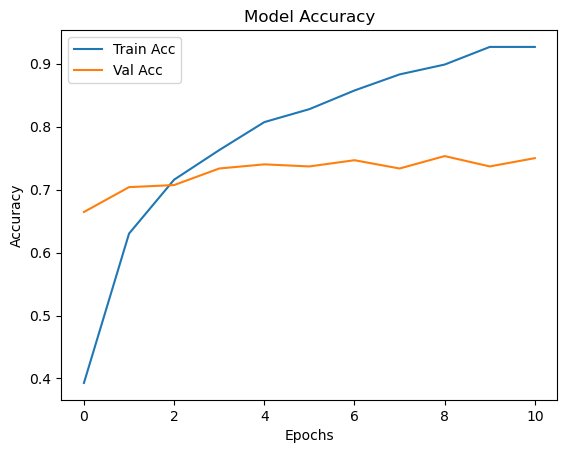

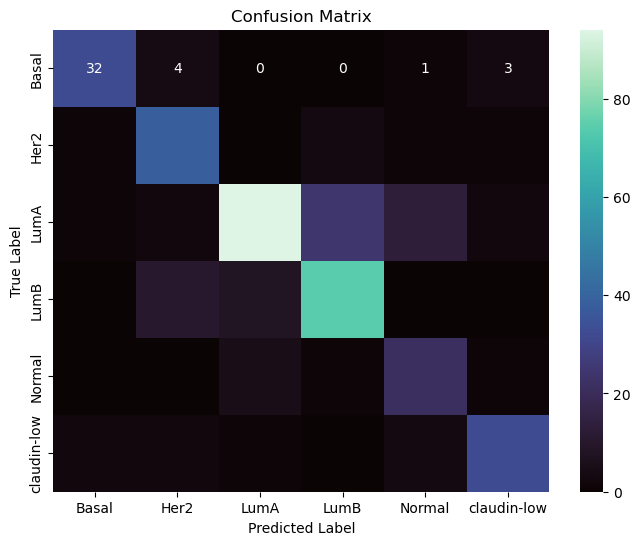

<Figure size 1000x500 with 0 Axes>

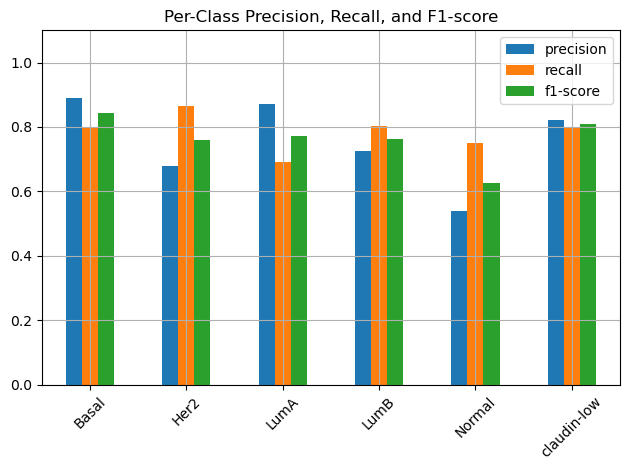

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


Sample 1 predicted as: LumB
Sample 2 predicted as: LumB
Sample 3 predicted as: LumB
Sample 4 predicted as: Her2
Sample 5 predicted as: LumB


In [1]:
# 🦦 Breast Cancer Subtype Classification using Deep Learning (METABRIC Dataset)

## 📅 Load & Preprocess Data
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.utils import class_weight

# Load the dataset
df = pd.read_csv("METABRIC_RNA_Mutation.csv", low_memory=False)

# Drop rows with missing subtype labels and drop rare class 'NC'
df = df.dropna(subset=["pam50_+_claudin-low_subtype"])
df = df[df["pam50_+_claudin-low_subtype"] != "NC"]

# Encode target variable
le = LabelEncoder()
df["subtype_encoded"] = le.fit_transform(df["pam50_+_claudin-low_subtype"])

# Drop non-feature columns and select only numeric features
non_feature_cols = df.columns[:30].tolist() + ["pam50_+_claudin-low_subtype", "subtype_encoded"]
X = df.drop(columns=non_feature_cols).select_dtypes(include='number')
y = df["subtype_encoded"]

# Optional: Select top 500 most variable genes
X_var = X.var().sort_values(ascending=False)
top_genes = X_var.head(500).index
X = X[top_genes]

# Scale the gene expression data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Train-test split
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

# Compute class weights for imbalanced classes
class_weights = class_weight.compute_class_weight(class_weight='balanced', classes=np.unique(y_train), y=y_train)
class_weights = dict(enumerate(class_weights))

## 🤖 Build & Train Deep Learning Model
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau

# One-hot encode target
y_train_cat = to_categorical(y_train)
y_test_cat = to_categorical(y_test)

# Define the model (rollback version that worked)
model = Sequential([
    Input(shape=(X_train.shape[1],)),
    Dense(128, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.3),
    Dense(64, activation='relu', kernel_regularizer=l2(0.001)),
    Dropout(0.2),
    Dense(y_train_cat.shape[1], activation='softmax')
])

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# Train the model
history = model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=50,
    batch_size=32,
    class_weight=class_weights,
    callbacks=[early_stop, reduce_lr]
)

## 📏 Evaluate Model
from sklearn.metrics import classification_report, confusion_matrix

# Evaluate on test set
loss, acc = model.evaluate(X_test, y_test_cat)
print(f"Test Accuracy: {acc:.4f}")

# Predict on test set
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)

# Classification report
print(classification_report(y_test, y_pred_classes, target_names=le.classes_))

## 📊 Visualize Performance and Diagnose
import matplotlib.pyplot as plt
import seaborn as sns

# Plot accuracy over epochs
plt.plot(history.history['accuracy'], label='Train Acc')
plt.plot(history.history['val_accuracy'], label='Val Acc')
plt.title('Model Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion matrix
conf = confusion_matrix(y_test, y_pred_classes)
plt.figure(figsize=(8, 6))
sns.heatmap(conf, annot=True, fmt='d', cmap='mako', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title("Confusion Matrix")
plt.ylabel("True Label")
plt.xlabel("Predicted Label")
plt.show()

# Per-class F1 score bar plot
from sklearn.metrics import classification_report
import pandas as pd

report_dict = classification_report(y_test, y_pred_classes, target_names=le.classes_, output_dict=True)
report_df = pd.DataFrame(report_dict).T[:-3]  # exclude avg rows

plt.figure(figsize=(10, 5))
report_df[['precision', 'recall', 'f1-score']].plot(kind='bar')
plt.title("Per-Class Precision, Recall, and F1-score")
plt.xticks(rotation=45)
plt.ylim(0, 1.1)
plt.grid(True)
plt.tight_layout()
plt.show()

## 🧪 Test on New Input
# Grab 5 random test patients
new_input = X_test[:5]

# Predict
y_pred = model.predict(new_input)
y_class = np.argmax(y_pred, axis=1)
predicted_labels = le.inverse_transform(y_class)

# Show results
for i, label in enumerate(predicted_labels):
    print(f"Sample {i+1} predicted as: {label}")

## 📀 Save Model
# Save the trained model
model.save("metabric_subtype_classifier.h5")


In [5]:
# Grab 5 samples
samples = X_test[:5]
true_labels = le.inverse_transform(y_test[:5])

# Predict
y_pred = model.predict(samples)
pred_classes = np.argmax(y_pred, axis=1)
pred_labels = le.inverse_transform(pred_classes)

# Print results
for i in range(5):
    print(f"Sample {i+1}: True = {true_labels[i]} | Predicted = {pred_labels[i]}")
    print("Class probabilities:")
    for class_idx, score in enumerate(y_pred[i]):
        label = le.inverse_transform([class_idx])[0]
        print(f"  {label}: {score:.4f}")
    print("-" * 30)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step
Sample 1: True = LumB | Predicted = LumB
Class probabilities:
  Basal: 0.0000
  Her2: 0.0015
  LumA: 0.1329
  LumB: 0.8651
  Normal: 0.0005
  claudin-low: 0.0000
------------------------------
Sample 2: True = Her2 | Predicted = LumB
Class probabilities:
  Basal: 0.0330
  Her2: 0.1147
  LumA: 0.3063
  LumB: 0.4816
  Normal: 0.0462
  claudin-low: 0.0182
------------------------------
Sample 3: True = LumB | Predicted = LumB
Class probabilities:
  Basal: 0.0005
  Her2: 0.0074
  LumA: 0.0837
  LumB: 0.9053
  Normal: 0.0031
  claudin-low: 0.0001
------------------------------
Sample 4: True = Her2 | Predicted = Her2
Class probabilities:
  Basal: 0.0941
  Her2: 0.5475
  LumA: 0.0582
  LumB: 0.0088
  Normal: 0.2528
  claudin-low: 0.0385
------------------------------
Sample 5: True = LumB | Predicted = LumB
Class probabilities:
  Basal: 0.0009
  Her2: 0.0023
  LumA: 0.1054
  LumB: 0.8893
  Normal: 0.0021
  claudin-low: 0.0000
----------------------------

In [11]:
# Grab 5 samples
samples = X_test[:10]
true_labels = le.inverse_transform(y_test[:10])

# Predict
y_pred = model.predict(samples)
pred_classes = np.argmax(y_pred, axis=1)
pred_labels = le.inverse_transform(pred_classes)

# Print side-by-side
print("📊 Predicted vs True Labels")
print("-" * 35)
for i in range(10):
    print(f"Sample {i+1}: Predicted = {pred_labels[i]:<12} | True = {true_labels[i]}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
📊 Predicted vs True Labels
-----------------------------------
Sample 1: Predicted = LumB         | True = LumB
Sample 2: Predicted = LumB         | True = Her2
Sample 3: Predicted = LumB         | True = LumB
Sample 4: Predicted = Her2         | True = Her2
Sample 5: Predicted = LumB         | True = LumB
Sample 6: Predicted = Normal       | True = claudin-low
Sample 7: Predicted = Basal        | True = Basal
Sample 8: Predicted = LumB         | True = LumB
Sample 9: Predicted = Her2         | True = LumB
Sample 10: Predicted = claudin-low  | True = claudin-low
